# Physics Models in HYPERION Simulation

This notebook walks through the physics models that power the HYPERION hypersonic threat interception simulation. Realistic physics are critical for training effective multi-agent reinforcement learning policies that can transfer to real-world scenarios.

## Why Physics Matter

Training AI agents in simulations with unrealistic physics leads to policies that fail in reality. For hypersonic threat interception, key physical phenomena include:

1. **Atmospheric Effects** - Air density, temperature, and pressure vary with altitude
2. **Aerodynamic Drag** - High-speed vehicles experience significant drag forces
3. **Sensor Limitations** - Detection probability decreases with range; measurements have noise
4. **Evasive Maneuvers** - Threats can execute complex trajectories to avoid interception

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')

from src.env.physics_models import (
    AtmosphereModel,
    AtmosphericConditions,
    HypersonicTrajectory,
    SensorModel,
    EvasiveManeuvers,
    calculate_intercept_point
)

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

/opt/miniconda3/envs/data_sci/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-30 21:45:23,725	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-12-30 21:45:27,450	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## 1. International Standard Atmosphere (ISA) Model

The atmosphere is not uniform - temperature, pressure, and density all change with altitude. Our simulation uses the International Standard Atmosphere model to capture these effects.

### Key Equations

**Temperature (Troposphere, 0-11km):**
$$T = T_0 + L \cdot h$$

Where:
- $T_0 = 288.15$ K (sea level temperature)
- $L = -0.0065$ K/m (lapse rate)
- $h$ = altitude in meters

**Pressure (Barometric Formula):**
$$P = P_0 \left(\frac{T}{T_0}\right)^{-g/(L \cdot R)}$$

**Density (Ideal Gas Law):**
$$\rho = \frac{P}{R \cdot T}$$

**Speed of Sound:**
$$a = \sqrt{\gamma \cdot R \cdot T}$$

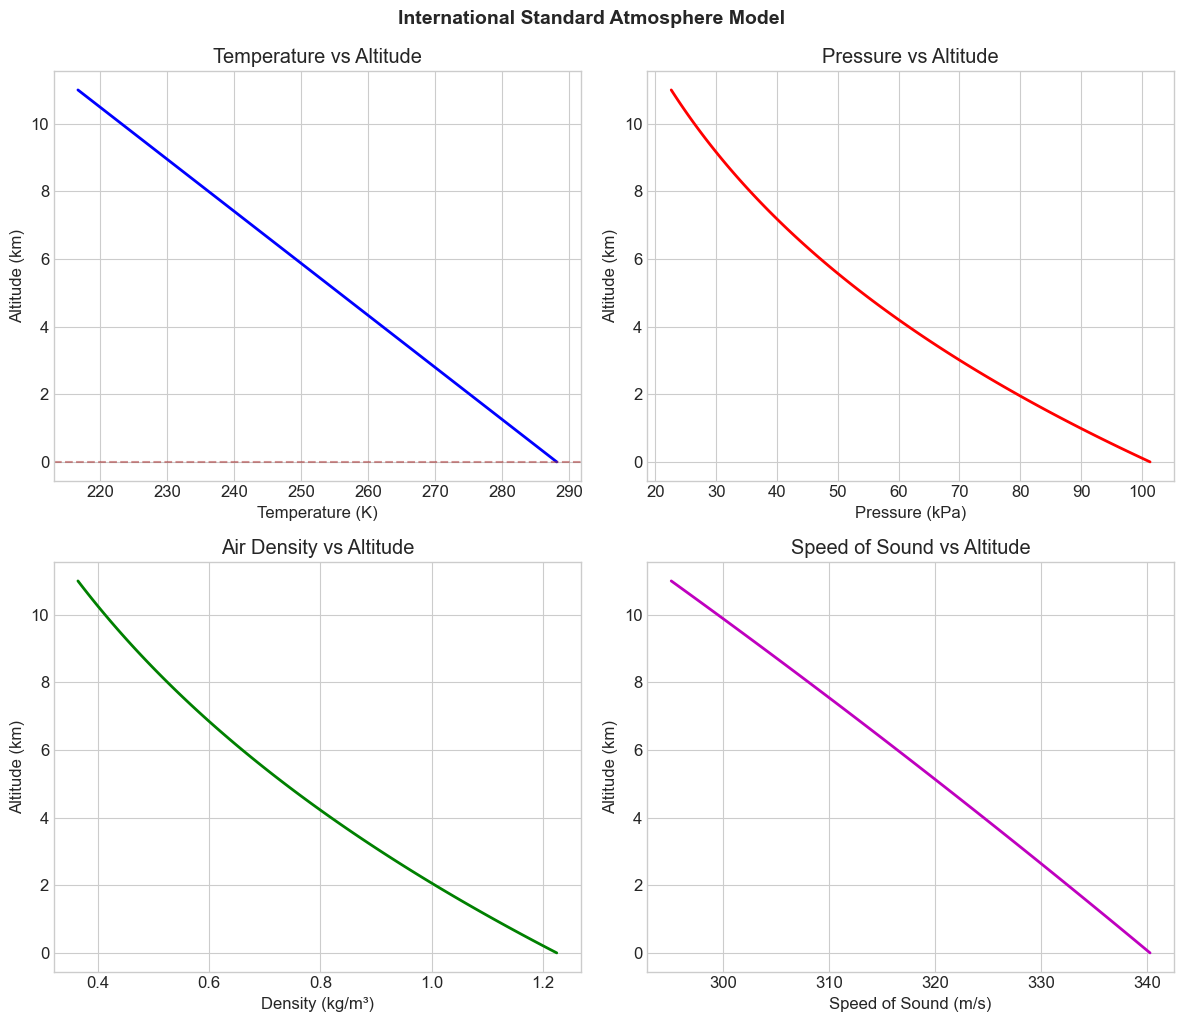

In [2]:
# Generate atmospheric profiles
altitudes = np.linspace(0, 11000, 100)  # 0 to 11km

temperatures = []
pressures = []
densities = []
speeds_of_sound = []

for alt in altitudes:
    conditions = AtmosphereModel.get_conditions(alt)
    temperatures.append(conditions.temperature)
    pressures.append(conditions.pressure)
    densities.append(conditions.density)
    speeds_of_sound.append(conditions.speed_of_sound)

# Plot atmospheric profiles
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(temperatures, altitudes/1000, 'b-', linewidth=2)
axes[0, 0].set_xlabel('Temperature (K)')
axes[0, 0].set_ylabel('Altitude (km)')
axes[0, 0].set_title('Temperature vs Altitude')
axes[0, 0].axhline(y=0, color='brown', linestyle='--', alpha=0.5, label='Sea Level')

axes[0, 1].plot(np.array(pressures)/1000, altitudes/1000, 'r-', linewidth=2)
axes[0, 1].set_xlabel('Pressure (kPa)')
axes[0, 1].set_ylabel('Altitude (km)')
axes[0, 1].set_title('Pressure vs Altitude')

axes[1, 0].plot(densities, altitudes/1000, 'g-', linewidth=2)
axes[1, 0].set_xlabel('Density (kg/m³)')
axes[1, 0].set_ylabel('Altitude (km)')
axes[1, 0].set_title('Air Density vs Altitude')

axes[1, 1].plot(speeds_of_sound, altitudes/1000, 'm-', linewidth=2)
axes[1, 1].set_xlabel('Speed of Sound (m/s)')
axes[1, 1].set_ylabel('Altitude (km)')
axes[1, 1].set_title('Speed of Sound vs Altitude')

plt.tight_layout()
plt.suptitle('International Standard Atmosphere Model', y=1.02, fontsize=14, fontweight='bold')
plt.show()

### Why This Matters for the Simulation

1. **Drag varies with altitude** - Lower density at high altitude means less drag
2. **Mach number changes** - Same velocity = different Mach at different altitudes
3. **UAV performance** - Drone capabilities depend on atmospheric conditions

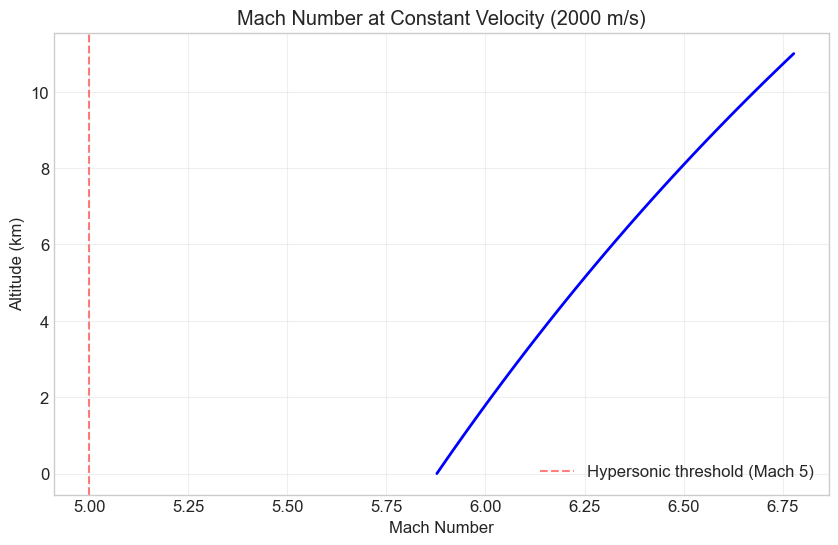

At sea level: Mach 5.88
At 10 km: Mach 6.68


In [3]:
# Demonstrate Mach number variation with altitude
velocity = 2000  # m/s (about Mach 6 at sea level)

mach_numbers = [AtmosphereModel.velocity_to_mach(velocity, alt) for alt in altitudes]

plt.figure(figsize=(10, 6))
plt.plot(mach_numbers, altitudes/1000, 'b-', linewidth=2)
plt.xlabel('Mach Number')
plt.ylabel('Altitude (km)')
plt.title(f'Mach Number at Constant Velocity ({velocity} m/s)')
plt.axvline(x=5, color='r', linestyle='--', alpha=0.5, label='Hypersonic threshold (Mach 5)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"At sea level: Mach {AtmosphereModel.velocity_to_mach(velocity, 0):.2f}")
print(f"At 10 km: Mach {AtmosphereModel.velocity_to_mach(velocity, 10000):.2f}")

## 2. Aerodynamic Drag Model

Hypersonic vehicles experience significant drag forces that slow them down. The drag equation is:

$$F_D = \frac{1}{2} \rho v^2 C_D A$$

Where:
- $\rho$ = air density (from atmosphere model)
- $v$ = velocity
- $C_D$ = drag coefficient
- $A$ = reference area

The drag force opposes the direction of motion, causing deceleration.

In [4]:
# Simulate hypersonic trajectory with drag
# Initial conditions: Mach 8 at sea level, horizontal flight

initial_velocity = AtmosphereModel.mach_to_velocity(8.0, 0)  # Mach 8
print(f"Initial velocity: {initial_velocity:.0f} m/s (Mach 8)")

trajectory = HypersonicTrajectory(
    initial_position=np.array([0.0, 0.0]),
    initial_velocity=np.array([initial_velocity, 0.0]),
    mass=1000.0,
    drag_coefficient=0.3,
    reference_area=0.5
)

# Simulate for 60 seconds
dt = 0.1
time_steps = int(60 / dt)

positions = []
velocities = []
times = []

for i in range(time_steps):
    pos, vel = trajectory.get_state()
    positions.append(pos.copy())
    velocities.append(np.linalg.norm(vel))
    times.append(i * dt)
    trajectory.update(dt, altitude=0)  # Sea level flight

positions = np.array(positions)
velocities = np.array(velocities)

# Convert velocities to Mach numbers
mach_numbers = [AtmosphereModel.velocity_to_mach(v, 0) for v in velocities]

Initial velocity: 2722 m/s (Mach 8)


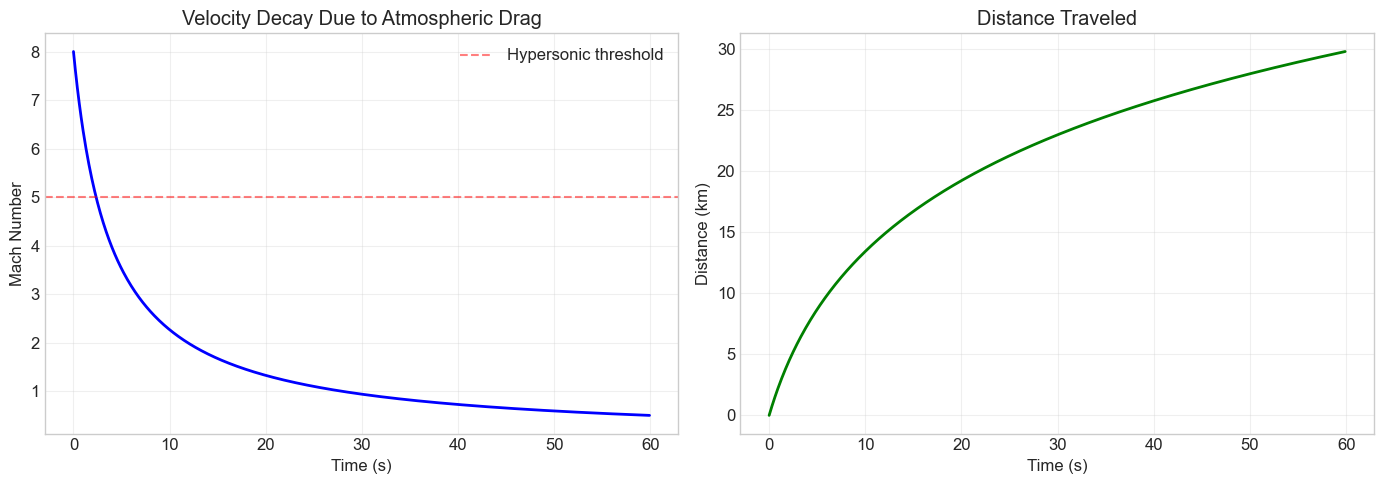


After 60 seconds:
  Final Mach: 0.50
  Distance traveled: 29.8 km
  Velocity lost: 93.8%


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Velocity decay
axes[0].plot(times, mach_numbers, 'b-', linewidth=2)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Mach Number')
axes[0].set_title('Velocity Decay Due to Atmospheric Drag')
axes[0].axhline(y=5, color='r', linestyle='--', alpha=0.5, label='Hypersonic threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distance traveled
axes[1].plot(times, positions[:, 0]/1000, 'g-', linewidth=2)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Distance (km)')
axes[1].set_title('Distance Traveled')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAfter 60 seconds:")
print(f"  Final Mach: {mach_numbers[-1]:.2f}")
print(f"  Distance traveled: {positions[-1, 0]/1000:.1f} km")
print(f"  Velocity lost: {(1 - velocities[-1]/velocities[0])*100:.1f}%")

### Impact on RL Training

The drag model affects training in several ways:

1. **Time pressure** - Threats slow down, giving interceptors more time at longer ranges
2. **Altitude strategy** - Flying higher reduces drag (potential evasion tactic)
3. **Intercept windows** - Optimal intercept points depend on predicted velocity

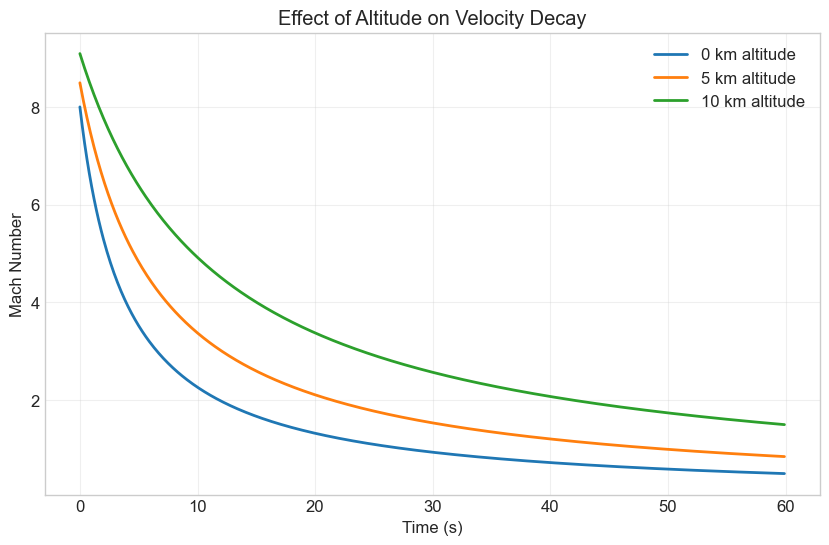

In [6]:
# Compare drag at different altitudes
altitudes_to_test = [0, 5000, 10000]  # meters

plt.figure(figsize=(10, 6))

for alt in altitudes_to_test:
    trajectory = HypersonicTrajectory(
        initial_position=np.array([0.0, 0.0]),
        initial_velocity=np.array([initial_velocity, 0.0]),
        mass=1000.0,
        drag_coefficient=0.3,
        reference_area=0.5
    )
    
    velocities_alt = []
    for i in range(time_steps):
        _, vel = trajectory.get_state()
        velocities_alt.append(AtmosphereModel.velocity_to_mach(np.linalg.norm(vel), alt))
        trajectory.update(dt, altitude=alt)
    
    plt.plot(times, velocities_alt, linewidth=2, label=f'{alt/1000:.0f} km altitude')

plt.xlabel('Time (s)')
plt.ylabel('Mach Number')
plt.title('Effect of Altitude on Velocity Decay')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Sensor Physics

Real sensors have limitations that our simulation must capture:

1. **Range-dependent detection** - Probability of detection decreases with distance
2. **Measurement noise** - All measurements have uncertainty
3. **Stochastic detection** - Detection is probabilistic, not deterministic

### Detection Probability Model

$$P_{detect} = P_{base} \cdot \left(1 - \frac{d}{d_{max}}\right)^2$$

This quadratic falloff models radar cross-section effects and atmospheric attenuation.

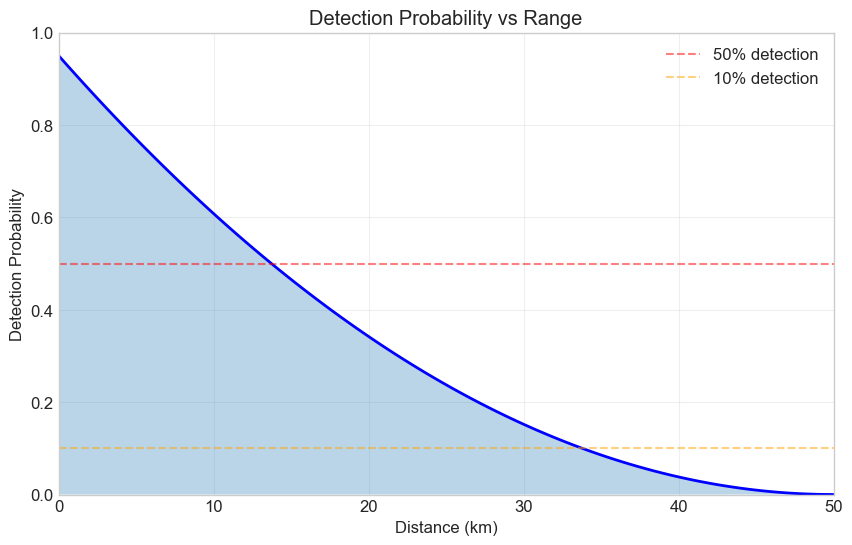

50% detection probability at 14.1 km
25% detection probability at 24.7 km
10% detection probability at 33.8 km


In [8]:
# Visualize detection probability vs range
max_range = 50000  # 50 km
distances = np.linspace(0, max_range, 100)

probabilities = [SensorModel.detection_probability(d, max_range, 0.95) for d in distances]

plt.figure(figsize=(10, 6))
plt.plot(distances/1000, probabilities, 'b-', linewidth=2)
plt.fill_between(distances/1000, probabilities, alpha=0.3)
plt.xlabel('Distance (km)')
plt.ylabel('Detection Probability')
plt.title('Detection Probability vs Range')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='50% detection')
plt.axhline(y=0.1, color='orange', linestyle='--', alpha=0.5, label='10% detection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, max_range/1000)
plt.ylim(0, 1)
plt.show()

# Find critical ranges
for target_prob in [0.5, 0.25, 0.1]:
    for d in distances:
        if SensorModel.detection_probability(d, max_range, 0.95) <= target_prob:
            print(f"{target_prob*100:.0f}% detection probability at {d/1000:.1f} km")
            break

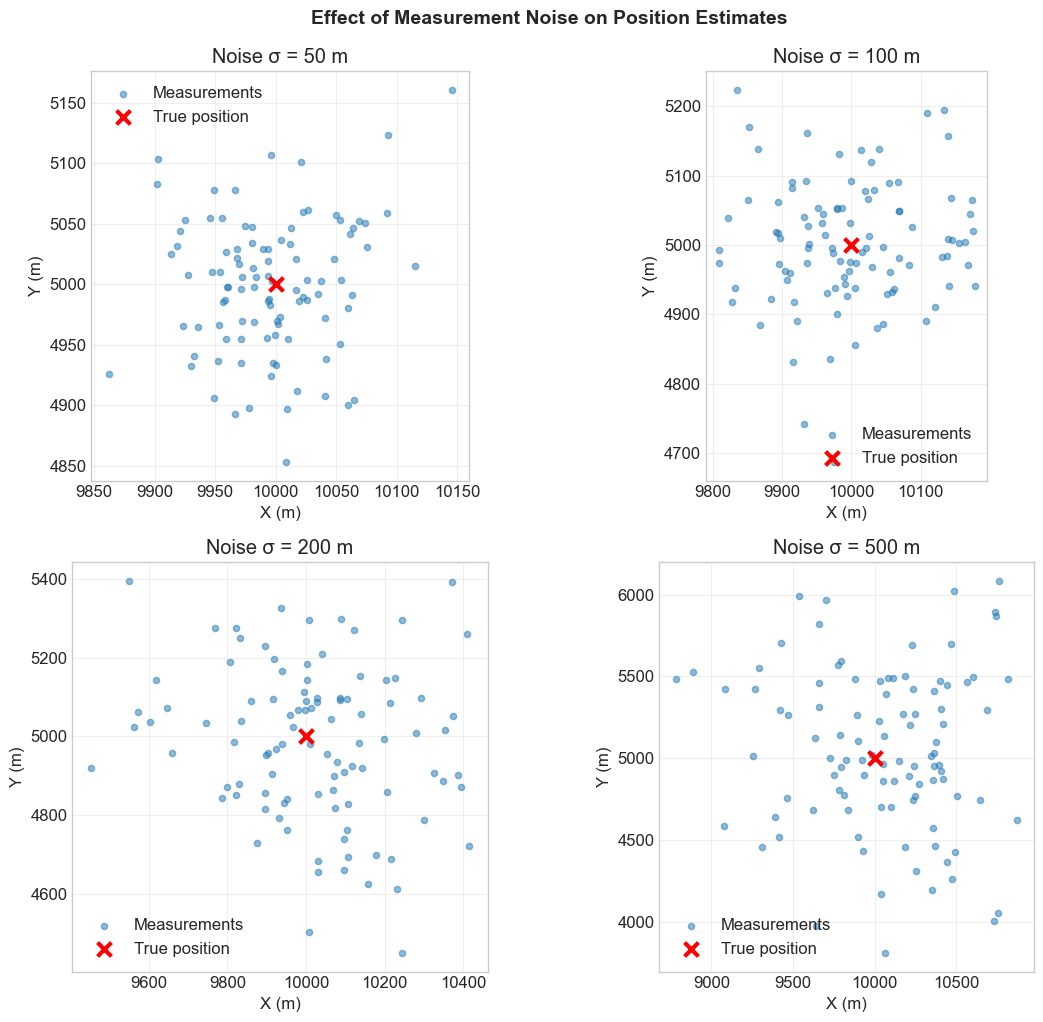

In [9]:
# Demonstrate measurement noise
true_position = np.array([10000.0, 5000.0])  # True target position
noise_levels = [50, 100, 200, 500]  # meters

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, noise_std in enumerate(noise_levels):
    # Generate 100 noisy measurements
    measurements = [SensorModel.add_measurement_noise(true_position, noise_std) for _ in range(100)]
    measurements = np.array(measurements)
    
    axes[idx].scatter(measurements[:, 0], measurements[:, 1], alpha=0.5, s=20, label='Measurements')
    axes[idx].scatter(*true_position, color='red', s=100, marker='x', linewidths=3, label='True position')
    axes[idx].set_xlabel('X (m)')
    axes[idx].set_ylabel('Y (m)')
    axes[idx].set_title(f'Noise σ = {noise_std} m')
    axes[idx].legend()
    axes[idx].set_aspect('equal')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Effect of Measurement Noise on Position Estimates', y=1.02, fontsize=14, fontweight='bold')
plt.show()

### Training Implications

Sensor limitations teach the RL agents important behaviors:

1. **Approach closer for reliable detection** - Can't engage what you can't see
2. **Handle uncertainty** - Make decisions with imperfect information
3. **Sensor fusion** - Multiple UAVs can improve tracking accuracy

## 4. Evasive Maneuvers

Hypersonic threats can execute evasive maneuvers to complicate interception. Our model includes:

1. **Sinusoidal weaving** - Predictable oscillation perpendicular to flight path
2. **Random jinking** - Sudden, unpredictable direction changes

These maneuvers test whether the RL agents can adapt to non-ballistic trajectories.

In [10]:
# Compare straight vs evasive trajectories
base_velocity = np.array([2000.0, 0.0])  # Mach ~6 horizontal

# Simulate different trajectory types
dt = 0.1
duration = 30  # seconds
times = np.arange(0, duration, dt)

trajectories = {
    'Straight': [],
    'Sinusoidal Weave': [],
    'Random Jink': []
}

np.random.seed(42)  # Reproducibility

for traj_type in trajectories:
    position = np.array([0.0, 0.0])
    
    for t in times:
        if traj_type == 'Straight':
            velocity = base_velocity
        elif traj_type == 'Sinusoidal Weave':
            velocity = EvasiveManeuvers.sinusoidal_weave(
                base_velocity, t, amplitude=200.0, frequency=0.2
            )
        else:  # Random Jink
            velocity = EvasiveManeuvers.random_jink(
                base_velocity, probability=0.05, magnitude=100.0
            )
        
        trajectories[traj_type].append(position.copy())
        position = position + velocity * dt

# Convert to arrays
for key in trajectories:
    trajectories[key] = np.array(trajectories[key])

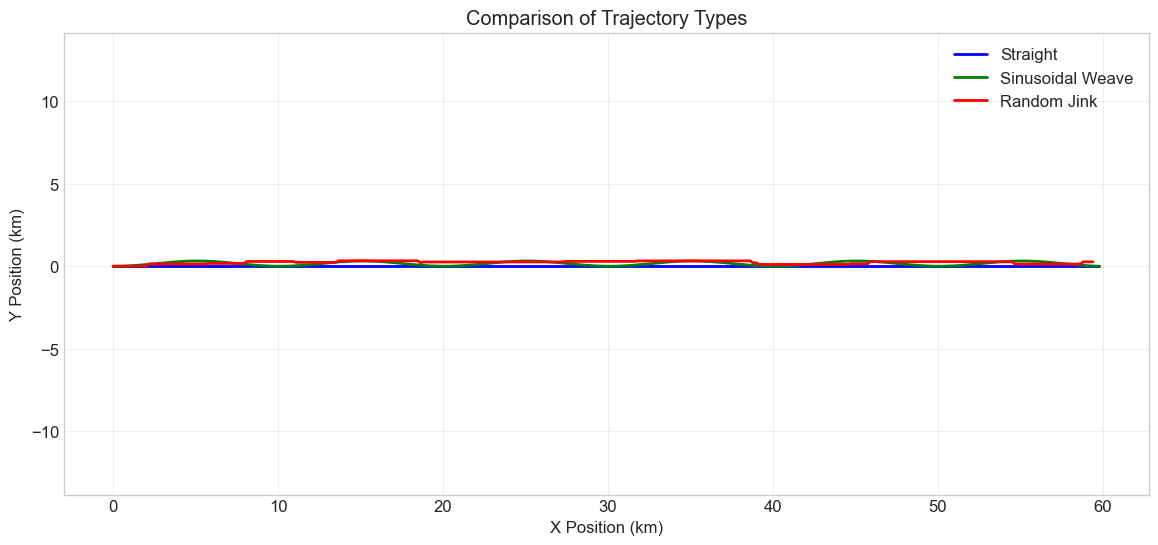

In [11]:
plt.figure(figsize=(14, 6))

colors = {'Straight': 'blue', 'Sinusoidal Weave': 'green', 'Random Jink': 'red'}

for traj_type, positions in trajectories.items():
    plt.plot(positions[:, 0]/1000, positions[:, 1]/1000, 
             color=colors[traj_type], linewidth=2, label=traj_type)

plt.xlabel('X Position (km)')
plt.ylabel('Y Position (km)')
plt.title('Comparison of Trajectory Types')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

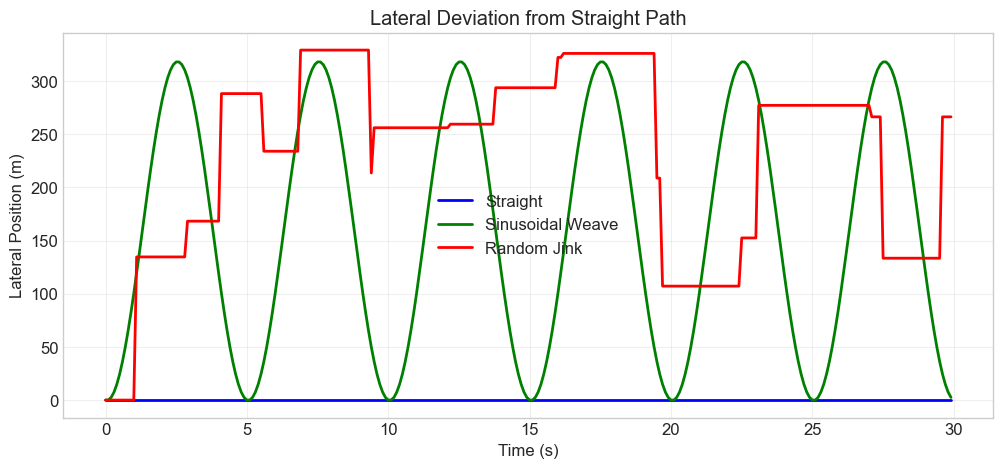

Maximum lateral deviations:
  Straight: 0 m
  Sinusoidal Weave: 318 m
  Random Jink: 329 m


In [12]:
# Zoom in on lateral deviation
plt.figure(figsize=(12, 5))

for traj_type, positions in trajectories.items():
    plt.plot(times, positions[:, 1], color=colors[traj_type], linewidth=2, label=traj_type)

plt.xlabel('Time (s)')
plt.ylabel('Lateral Position (m)')
plt.title('Lateral Deviation from Straight Path')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Maximum lateral deviations:")
for traj_type, positions in trajectories.items():
    max_dev = np.max(np.abs(positions[:, 1]))
    print(f"  {traj_type}: {max_dev:.0f} m")

## 5. Intercept Calculation

The simulation includes a proportional navigation algorithm for calculating intercept points. This represents the fundamental challenge: predicting where a moving target will be and positioning to intercept.

### Key Insight

For successful interception:
$$v_{interceptor} > v_{target} \cdot \cos(\theta)$$

Where $\theta$ is the angle between target velocity and the line of sight.

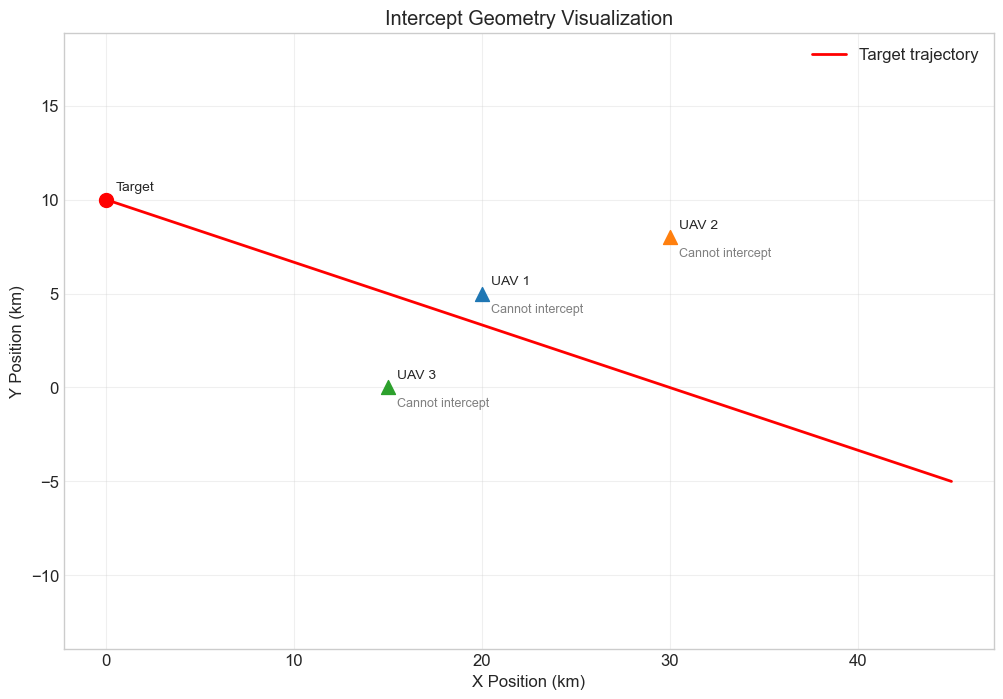

In [13]:
# Visualize intercept geometry
target_pos = np.array([0.0, 10000.0])
target_vel = np.array([1500.0, -500.0])  # Moving right and down

# Multiple interceptor positions
interceptor_positions = [
    np.array([20000.0, 5000.0]),
    np.array([30000.0, 8000.0]),
    np.array([15000.0, 0.0]),
]
interceptor_speed = 800.0  # m/s (slower than target)

plt.figure(figsize=(12, 8))

# Plot target trajectory
t_future = np.linspace(0, 30, 100)
target_trajectory = target_pos + np.outer(t_future, target_vel)
plt.plot(target_trajectory[:, 0]/1000, target_trajectory[:, 1]/1000, 
         'r-', linewidth=2, label='Target trajectory')
plt.scatter(*target_pos/1000, color='red', s=100, marker='o', zorder=5)
plt.annotate('Target', target_pos/1000 + np.array([0.5, 0.5]), fontsize=10)

# Plot interceptors and their intercept points
for i, int_pos in enumerate(interceptor_positions):
    intercept_pt = calculate_intercept_point(
        target_pos, target_vel, int_pos, interceptor_speed
    )
    
    color = f'C{i}'
    plt.scatter(*int_pos/1000, color=color, s=100, marker='^', zorder=5)
    plt.annotate(f'UAV {i+1}', int_pos/1000 + np.array([0.5, 0.5]), fontsize=10)
    
    if intercept_pt is not None:
        plt.scatter(*intercept_pt/1000, color=color, s=150, marker='*', zorder=5)
        plt.plot([int_pos[0]/1000, intercept_pt[0]/1000], 
                 [int_pos[1]/1000, intercept_pt[1]/1000],
                 color=color, linestyle='--', alpha=0.7, label=f'UAV {i+1} intercept path')
    else:
        plt.annotate(f'Cannot intercept', int_pos/1000 + np.array([0.5, -1]), 
                     fontsize=9, color='gray')

plt.xlabel('X Position (km)')
plt.ylabel('Y Position (km)')
plt.title('Intercept Geometry Visualization')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

## 6. Putting It All Together

Let's run a complete simulation showing how all physics components interact.

In [14]:
# Full simulation with all physics
np.random.seed(123)

# Initialize threat
threat = HypersonicTrajectory(
    initial_position=np.array([0.0, 50000.0]),
    initial_velocity=np.array([2500.0, -500.0]),  # Mach 7+, diving
    mass=1000.0,
    drag_coefficient=0.3,
    reference_area=0.5
)

# UAV sensor parameters
sensor_range = 30000  # 30 km
sensor_noise = 100  # meters

# Simulation
dt = 0.5
duration = 40
times = np.arange(0, duration, dt)

# Storage
true_positions = []
measured_positions = []
detections = []
mach_numbers = []

uav_position = np.array([40000.0, 20000.0])  # Static UAV for simplicity

for t in times:
    # Get true state
    pos, vel = threat.get_state()
    true_positions.append(pos.copy())
    
    # Apply evasive maneuvers to velocity
    evasive_vel = EvasiveManeuvers.sinusoidal_weave(vel, t, amplitude=100, frequency=0.15)
    evasive_vel = EvasiveManeuvers.random_jink(evasive_vel, probability=0.02, magnitude=50)
    threat.velocity = evasive_vel
    
    # Calculate Mach number
    altitude = max(pos[1], 0)  # Use Y as altitude approximation
    mach = AtmosphereModel.velocity_to_mach(np.linalg.norm(vel), altitude)
    mach_numbers.append(mach)
    
    # Sensor physics
    distance = np.linalg.norm(pos - uav_position)
    detected = SensorModel.is_detected(distance, sensor_range)
    detections.append(detected)
    
    if detected:
        measured = SensorModel.add_measurement_noise(pos, sensor_noise)
    else:
        measured = np.array([np.nan, np.nan])
    measured_positions.append(measured)
    
    # Update trajectory with drag
    threat.update(dt, altitude=altitude)

true_positions = np.array(true_positions)
measured_positions = np.array(measured_positions)

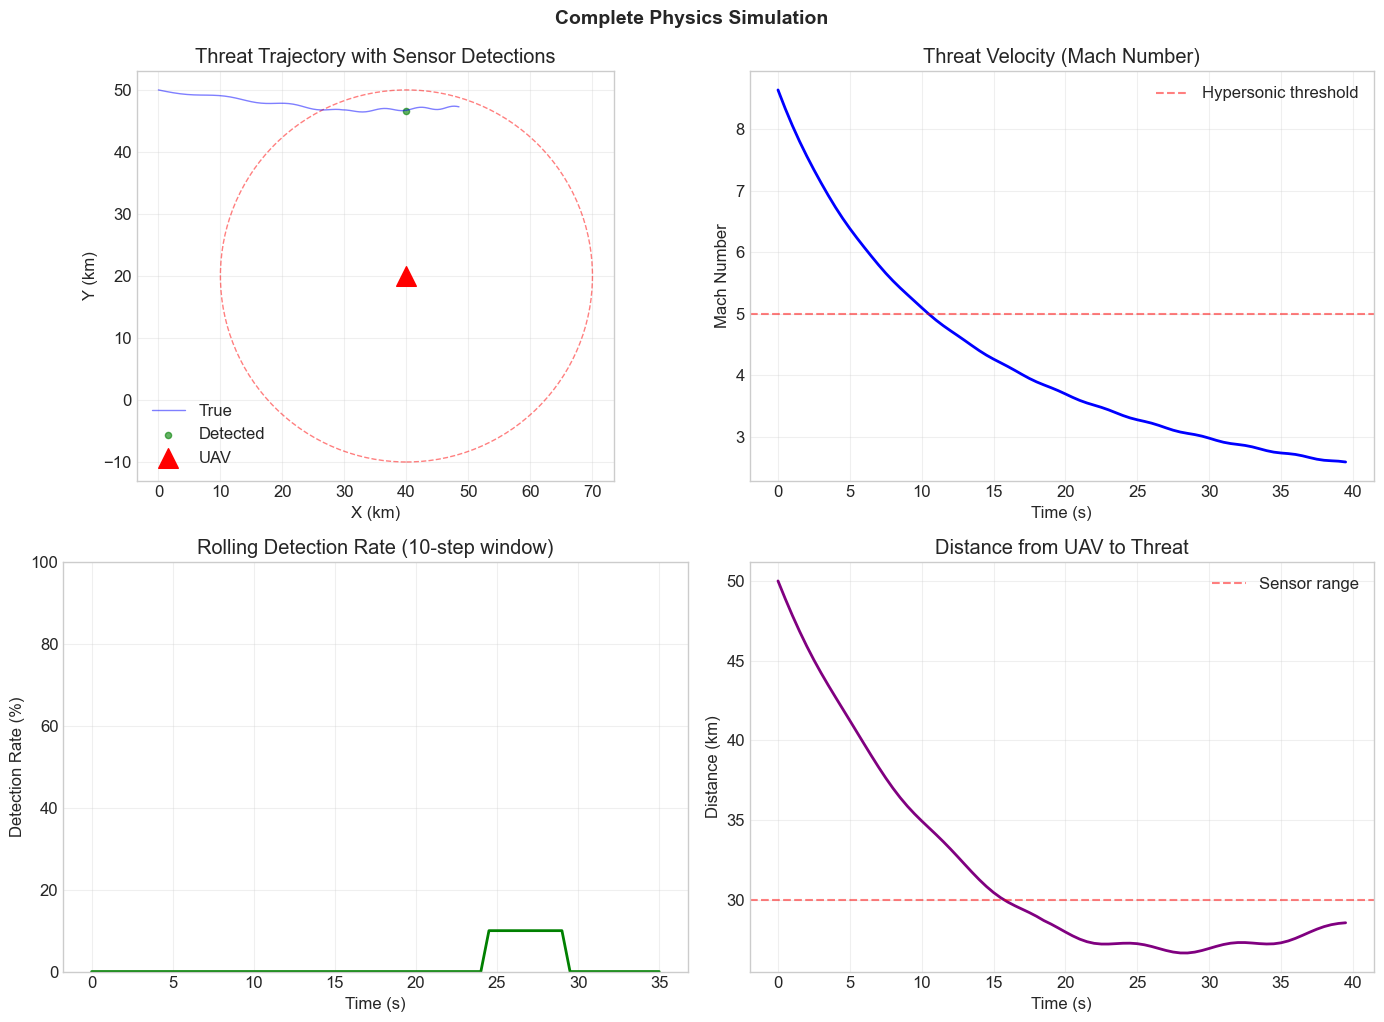

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Trajectory with detections
ax = axes[0, 0]
ax.plot(true_positions[:, 0]/1000, true_positions[:, 1]/1000, 'b-', linewidth=1, alpha=0.5, label='True')
detected_mask = np.array(detections)
ax.scatter(measured_positions[detected_mask, 0]/1000, measured_positions[detected_mask, 1]/1000,
           c='green', s=20, alpha=0.6, label='Detected')
ax.scatter(*uav_position/1000, color='red', s=200, marker='^', label='UAV')
circle = plt.Circle(uav_position/1000, sensor_range/1000, fill=False, color='red', linestyle='--', alpha=0.5)
ax.add_patch(circle)
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_title('Threat Trajectory with Sensor Detections')
ax.legend()
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Mach number over time
ax = axes[0, 1]
ax.plot(times, mach_numbers, 'b-', linewidth=2)
ax.axhline(y=5, color='r', linestyle='--', alpha=0.5, label='Hypersonic threshold')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Mach Number')
ax.set_title('Threat Velocity (Mach Number)')
ax.legend()
ax.grid(True, alpha=0.3)

# Detection rate over time
ax = axes[1, 0]
window = 10
detection_rate = np.convolve(detected_mask.astype(float), np.ones(window)/window, mode='valid')
ax.plot(times[:len(detection_rate)], detection_rate * 100, 'g-', linewidth=2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Detection Rate (%)')
ax.set_title('Rolling Detection Rate (10-step window)')
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)

# Distance to UAV
ax = axes[1, 1]
distances = np.linalg.norm(true_positions - uav_position, axis=1)
ax.plot(times, distances/1000, 'purple', linewidth=2)
ax.axhline(y=sensor_range/1000, color='r', linestyle='--', alpha=0.5, label='Sensor range')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance (km)')
ax.set_title('Distance from UAV to Threat')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Complete Physics Simulation', y=1.02, fontsize=14, fontweight='bold')
plt.show()

## Summary

The physics models in HYPERION provide a realistic training environment for multi-agent RL:

| Component | Purpose | Training Impact |
|-----------|---------|----------------|
| Atmosphere Model | Realistic air density/temperature | Altitude-dependent performance |
| Drag Model | Velocity decay over time | Time-critical decision making |
| Sensor Model | Range-limited, noisy detection | Uncertainty handling, cooperation |
| Evasive Maneuvers | Non-ballistic trajectories | Adaptive interception strategies |
| Intercept Calculation | Engagement geometry | Spatial reasoning |

These realistic physics ensure that learned policies can transfer to real-world scenarios rather than exploiting simulation artifacts.